In [1]:
import soccerdata as sd
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as pd
import numpy as np
import pyarrow
import seaborn as sb
import csv
import os
from mplsoccer import VerticalPitch, Pitch
import math

[01/02/26 16:30:09] INFO     No custom team name replacements found. You can configure these in       ]8;id=354553;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=661859;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py#91\91]8;;\
                             C:\Users\User\soccerdata\config\teamname_replacements.json.                           

                    INFO     Custom league dict loaded from                                          ]8;id=780223;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=322605;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py#195\195]8;;\
                             C:\Users\User\soccerdata\config\league_dict.json.                                     

In [2]:
ws = ws = sd.WhoScored(leagues="ENG-Premier League", seasons=2025)

[01/02/26 16:30:10] INFO     Saving cached data to C:\Users\User\soccerdata\data\WhoScored           ]8;id=36455;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=462861;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

In [3]:
"""player_list = []
import socceraction.spadl as spadl
for i in range(len(games)):
    gamepath = games[i]
    game = pd.read_csv(DIR+'/'+gamepath)
    the_id = game.game_id
    the_id = the_id[0]
    the_id = the_id.item()
    loader = ws.read_events(match_id = the_id, output_fmt="loader")
    player = loader.players(the_id)
    player_list.append(player)
    path = f'games_players/{the_id}_players.csv'
    player.to_csv(path)
    i+=1"""

'player_list = []\nimport socceraction.spadl as spadl\nfor i in range(len(games)):\n    gamepath = games[i]\n    game = pd.read_csv(DIR+\'/\'+gamepath)\n    the_id = game.game_id\n    the_id = the_id[0]\n    the_id = the_id.item()\n    loader = ws.read_events(match_id = the_id, output_fmt="loader")\n    player = loader.players(the_id)\n    player_list.append(player)\n    path = f\'games_players/{the_id}_players.csv\'\n    player.to_csv(path)\n    i+=1'

In [4]:
def player_details(game_id):
    id = game_id.item()
    loader = ws.read_events(match_id = id, output_fmt="loader")
    player = loader.players(id)
    return player

In [5]:
def find_opp(df):
    teams = df['team'].sort_values().to_list()
    opposition = ''
    if teams[0] == 'Man Utd':
        return teams[-1]
    else:
        return  teams[0]

In [36]:
def splitter(df):
    return_df = df[(df['type'] == 'Pass') & (df['outcome_type'] == 'Successful')]
    return_df['x']*=1.2
    return_df['end_x']*=1.2
    return_df['y']*=0.8
    return_df['end_y']*=0.8
    return_df.insert(1, "pass_angle",
                      np.degrees(np.arctan2(
                        return_df['end_y'] - return_df['y'],
                        return_df['end_x'] - return_df['x']
                      ))
                     )
    return_df.insert(2, "pass_angle_abs",
                     np.abs(return_df['pass_angle'])
                     )
    return_df.insert(3, 'receiver',
                     return_df['player_id'].shift(-1)
                     )
    return return_df

In [40]:
def pass_comb(df):
    df['pos_min'] = df[['player_id', 'receiver']].min(axis = 1)
    df['pos_max'] = df[['player_id', 'receiver']].max(axis = 1)

    passing_comb = df.groupby(['pos_min', 'pos_max']).size().reset_index(name='pass_count')

    return passing_comb

In [35]:
def enhance_position(passdf, game_id, list_players):
    avg_locs = passdf.groupby('player_id').agg({
        'x': 'median',
        'y': 'median',
        'player_id': 'count'
    })
    id = str(game_id)
    path = 'games_players/'+id+'_players.csv'
    game = pd.read_csv(path)


    game.set_index('player_id', inplace=True)
    avg_locs.columns = ['x_avg','y_avg','counts']
    avg_locs = avg_locs.merge(game, on='player_id', how='outer')
    return avg_locs

In [9]:
def team_metric(df, location, team_id):
    passes = df
    valid_pass = passes[
        (passes['pass_angle_abs'] >= 0)&
        (passes['pass_angle_abs'] <= 90)
    ]
    median_angle = valid_pass['pass_angle_abs'].median()
    verticality = round((1 - median_angle/90) * 100, 2)
    center_backs = location[location['starting_position'] == 'DC']
    defense_line = center_backs['x_avg'].median() if len(center_backs) > 0 else 30

    attackers = location[location['starting_position'].isin(['FW', 'AMC'])]
    forward_line = attackers['x_avg'].mean() if len(attackers) > 0 else 90
    team_median = location['x_avg'].median()

    return {
        'verticality': verticality,
        'defense_line': defense_line,
        'forward_line': forward_line,
        'team_median': team_median
    }


In [23]:
def plotter(ax, passes_df, avg_locs, pass_combinations, team_metrics,
                         team_name, color='blue',bg_color='#0C0D0E'):
    pitch = Pitch(pitch_type='statsbomb', line_color='white', pitch_color=bg_color, linewidth=1)
    pitch.draw(ax=ax)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.set_facecolor(bg_color)


    combinations = pass_combinations.merge(
        avg_locs[['x_avg', 'y_avg', 'player_name']],
        left_on='pos_min', right_index=True
    ).merge(
        avg_locs[['x_avg', 'y_avg', 'player_name']],
        left_on='pos_max', right_index=True,
        suffixes=['', '_end']
    )


    max_passes = combinations['pass_count'].max()
    combinations['line_width'] = (combinations['pass_count'] / max_passes) * 15
    combinations['alpha'] = 0.3 + (combinations['pass_count'] / max_passes) * 0.6


    for _, row in combinations.iterrows():
        pitch.lines(row['x_avg'], row['y_avg'], row['x_avg_end'], row['y_avg_end'],
                   lw=row['line_width'], color=color, alpha=row['alpha'], ax=ax, zorder=1)

    defense_line = team_metrics['defense_line']
    forward_line = team_metrics['forward_line']
    team_median = team_metrics['team_median']

    ax.axvline(x=defense_line, color='lightgray', linestyle='dotted', alpha=0.6, linewidth=2, zorder=2)
    ax.axvline(x=forward_line, color='lightgray', linestyle='dotted', alpha=0.6, linewidth=2, zorder=2)
    ax.axvline(x=team_median, color='lightgray', linestyle='--', alpha=0.8, linewidth=2, zorder=2)

    min_line = min(defense_line, forward_line)
    max_line = max(defense_line, forward_line)
    ymid = [0, 0, 80, 80]
    xmid = [min_line, max_line, max_line, min_line]
    ax.fill(xmid, ymid, color, alpha=0.1, zorder=0)

    for player_id, row in avg_locs.iterrows():
        marker = 'o' if row['is_starter'] else 's'
        pitch.scatter(row['x_avg'], row['y_avg'], s=1200, marker=marker,
                     color='white', edgecolors=color, linewidth=3, ax=ax, zorder=3)

        ax.text(row['x_avg'], row['y_avg'], str(row['jersey_number']),
                ha='center', va='center', fontsize=14, color=color, weight='bold', zorder=4)

    ax.text(115, 75, "○ = starter\n□ = substitute",
            fontsize=11, ha='right', va='top', color='white',
            bbox=dict(boxstyle="round,pad=0.3", facecolor=bg_color, edgecolor='white', alpha=0.8))
    ax.text(10, -8, f"Verticality: {team_metrics['verticality']}%",
            fontsize=12, ha='left', color='white', weight='bold')
    ax.text(70, -8, f"Median: {team_metrics['team_median']:.1f}m",
            fontsize=12, ha='left', color='white', weight='bold')

    ax.set_title(f"{team_name} - Passing Network", fontsize=14, color='white')

         team  pass_angle  pass_angle_abs  receiver            player  \
18    Man Utd  157.558441      157.558441  320374.0       Diogo Dalot   
19    Man Utd  -28.962735       28.962735  437299.0  Matthijs de Ligt   
20    Man Utd  165.988864      165.988864  320374.0         Leny Yoro   
21    Man Utd   95.710593       95.710593  118244.0  Matthijs de Ligt   
22    Man Utd  -98.693904       98.693904  320374.0         Luke Shaw   
...       ...         ...             ...       ...               ...   
1406  Man Utd  -19.097116       19.097116  353377.0    Benjamin Sesko   
1407  Man Utd -142.125016      142.125016  361707.0      Bryan Mbeumo   
1428  Man Utd  -46.073939       46.073939  353377.0    Altay Bayindir   
1429  Man Utd   65.462272       65.462272  361707.0      Bryan Mbeumo   
1440  Man Utd  -71.848114       71.848114       NaN    Altay Bayindir   

      player_id  minute  type outcome_type  second      x      y  end_x  end_y  
18     353418.0       1  Pass   Successful

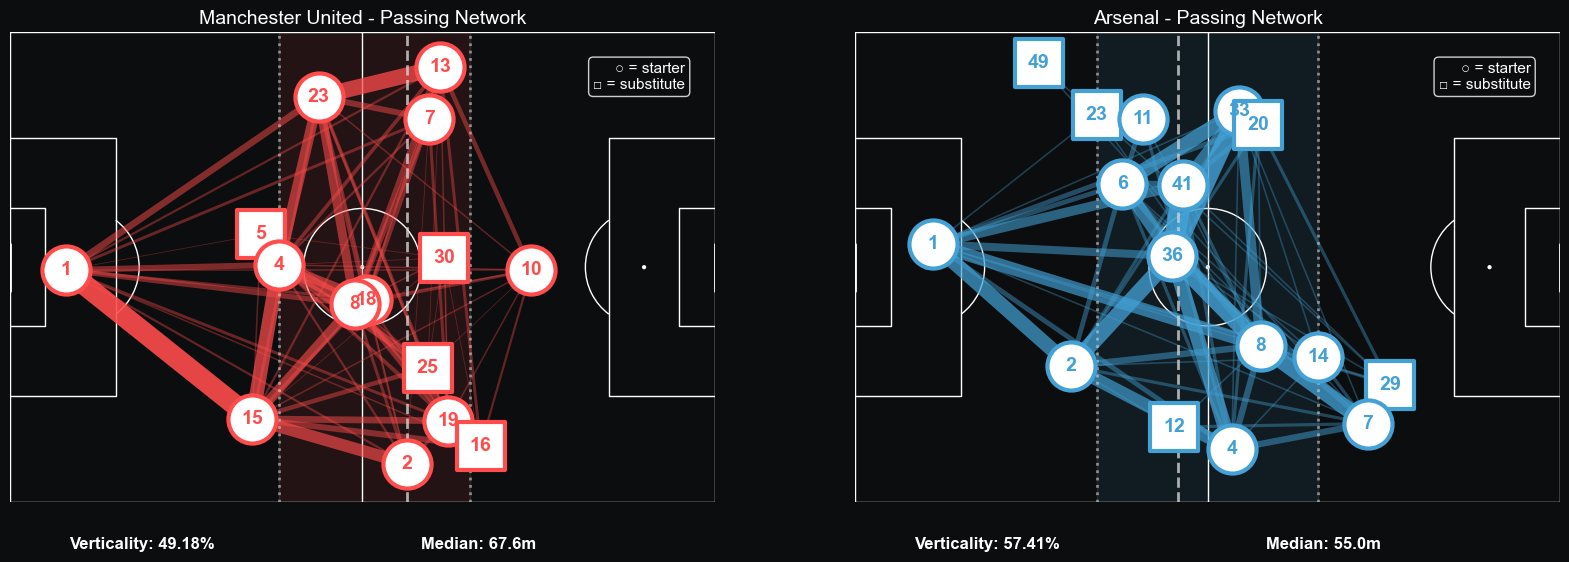

In [42]:
import warnings
warnings.filterwarnings('ignore')

DIR = 'utd_games'
num = sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR))
games = []
for i in range(num):
    games.append(os.listdir(DIR)[i])
game = pd.read_csv(DIR+'/'+games[0])
gameId = game.game_id[0]
gameId = gameId.astype(int)

pass_df = game[['team','player','player_id','minute','type','outcome_type','second','x', 'y','end_x','end_y']]


opposition = find_opp(pass_df)
mutd_df = pass_df[pass_df['team'] == 'Man Utd']
opposition_df = pass_df[pass_df['team'] == opposition]

mutd_pass_df = splitter(mutd_df)
opposition_pass_df = splitter(opposition_df)

mutd_pass_comb = pass_comb(mutd_pass_df)
opposition_pass_comb = pass_comb(opposition_pass_df)

mutd_avg_location = enhance_position(mutd_pass_df, gameId, mutd_pass_comb)
opposition_avg_location = enhance_position(opposition_pass_df, gameId,opposition_pass_comb)

mutd_team_metric = team_metric(mutd_pass_df, mutd_avg_location ,gameId)
opposition_team_metric = team_metric(opposition_pass_df, opposition_avg_location ,gameId)

background_color ='#0C0D0E'
home_color ='#FF4C4C'
away_color ='#43A1D5'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.patch.set_facecolor(background_color)

plotter(ax1, mutd_df, mutd_avg_location, mutd_pass_comb, mutd_team_metric,
                     'Manchester United', color=home_color, bg_color=background_color)

plotter(ax2, opposition_df, opposition_avg_location,opposition_pass_comb, opposition_team_metric,
                     opposition, color=away_color, bg_color=background_color)